## Import modules and data

In [12]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

In [57]:
filename = '../data/original/all_hourly_data.h5'
df_vitals = pd.read_hdf(filename, 'vitals_labs_mean')
df_inter = pd.read_hdf(filename, 'interventions')

In [28]:
multi_to_patid = pd.read_csv('../data/processed/multi_to_patid.csv')
multi_to_patid.set_index(keys=['subject_id','hadm_id','icustay_id'], inplace=True)

## Prepare vitals

In [58]:
df_vitals.columns = df_vitals.columns.droplevel(level=1)
df_vitals = df_vitals.join(multi_to_patid)
df_vitals.reset_index(inplace=True)
df_vitals.set_index(['pat_id','hours_in'], inplace=True)
df_vitals.drop(['subject_id','hadm_id','icustay_id'], axis=1, inplace=True)

### Interpolate Null Values

In [59]:
df_vitals = df_vitals.groupby(level=0).apply(lambda pat: pat.interpolate(method='linear', axis=0, limit_direction='both'))
df_vitals.index.set_names('remove_level', level=0, inplace=True)
df_vitals = df_vitals.droplevel(level='remove_level')
df_vitals = df_vitals.apply(lambda col: col.fillna(col.mean()), axis=0)

## Prepare interventions

In [61]:
df_inter = df_inter.join(multi_to_patid)
df_inter.reset_index(inplace=True)
df_inter.set_index(['pat_id','hours_in'], inplace=True)
df_inter.drop(['subject_id','hadm_id','icustay_id'], axis=1, inplace=True)

### Discover optimal cap on the `hours_in` attribute.

In [62]:
def displayDist(dist: np.array, title: str):
    mean, p5, p50, p95 = dist.mean(), np.percentile(dist, 5), np.percentile(dist, 50),  np.percentile(dist, 95)

    bin_vals, _, _ = plt.hist(dist, bins=30)
    
    x_top, y_top = max(dist), max(bin_vals)
    plt.xlim([0,x_top])
    plt.ylim([0,y_top])
    
    plt.plot([mean,mean],[0, y_top], label='Mean', linewidth=2)
    plt.plot([p5,p5],[0, y_top], '--', label='p5%', linewidth=2)
    plt.plot([p50,p50],[0, y_top], '--', label='p50%', linewidth=2)
    plt.plot([p95,p95],[0, y_top], '--', label='p95%', linewidth=2)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
    print("Mean: %f" % mean)
    print("5%% Percentile: %d" % p5)
    print("50%% Percentile: %d" % p50)
    print("95%% Percentile: %d" % p95)

In [63]:
hours_in_vital = df_vitals.index.get_level_values(1).to_numpy()
hours_in_inter = df_inter.index.get_level_values(1).to_numpy()

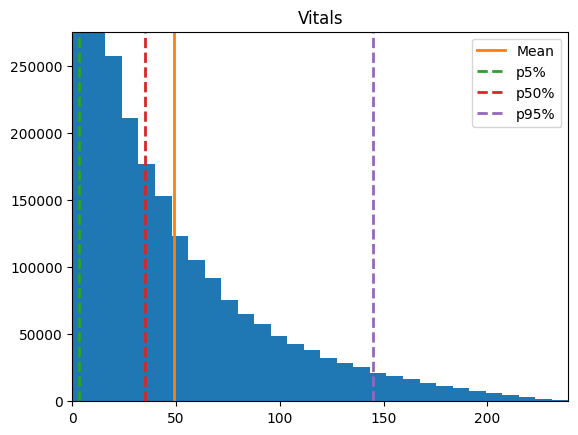

Mean: 49.160706
5% Percentile: 3
50% Percentile: 35
95% Percentile: 145


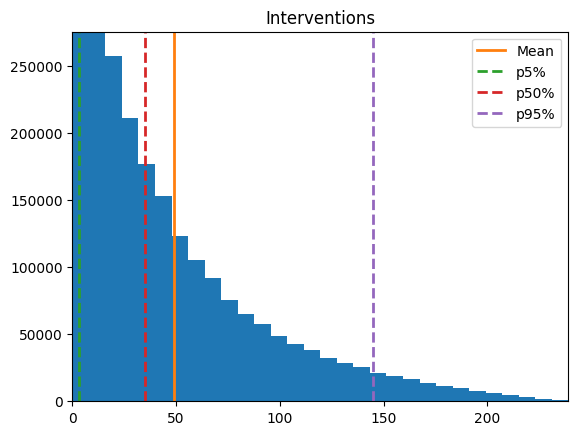

Mean: 49.160706
5% Percentile: 3
50% Percentile: 35
95% Percentile: 145


In [64]:
displayDist(hours_in_vital, 'Vitals')
displayDist(hours_in_inter, 'Interventions')

In [72]:
v = 150
print(f"""{v} hours_in will fully capture {round(sum(v > hours_in_vital) / hours_in_vital.shape[0] * 100, 2)}% of vitals""")
print(f"""{v} hours_in will fully capture {round(sum(v > hours_in_inter) / hours_in_inter.shape[0] * 100, 2)}% of interventions""")

150 hours_in will fully capture 95.49% of vitals
150 hours_in will fully capture 95.49% of interventions


In [71]:
pat_ids = df_vitals.index.get_level_values(0).unique()
pat_len = np.array([max(df_vitals.loc[pat_id].index) for pat_id in pat_ids])

In [73]:
print(f"""{v} hours_in will fully capture {round(sum(v > pat_len) / pat_len.shape[0] * 100, 2)}% of patients""")
print(f"""{v} hours_in will fully capture {round(sum(v > pat_len) / pat_len.shape[0] * 100, 2)}% of patients""")

150 hours_in will fully capture 92.73% of patients
150 hours_in will fully capture 92.73% of patients


### Select first 150 hours for each patient

In [77]:
df_vitals = df_vitals.loc[df_vitals.index.get_level_values(1) < 150]
df_inter = df_inter.loc[df_inter.index.get_level_values(1) < 150]

### Split & Save Results

In [79]:
processed_dir = '../data/processed/'
csv_vitals_filename = 'vitals.csv'
csv_inters_filename = 'interventions.csv'

In [80]:
train_idxs = np.load(os.path.join(processed_dir, 'train_idxs.npy'))
test_idxs = np.load(os.path.join(processed_dir, 'test_idxs.npy'))

In [81]:
df_vit_train = df_vitals.loc[train_idxs].copy()
df_vit_test = df_vitals.loc[test_idxs].copy()

In [82]:
df_int_train = df_inter.loc[train_idxs].copy()
df_int_test = df_inter.loc[test_idxs].copy()

In [83]:
df_vit_train.to_csv(os.path.join(processed_dir, 'train/', csv_vitals_filename))

In [84]:
df_vit_test.to_csv(os.path.join(processed_dir, 'test/', csv_vitals_filename))

In [85]:
df_int_train.to_csv(os.path.join(processed_dir, 'train/', csv_inters_filename))
df_int_test.to_csv(os.path.join(processed_dir, 'test/', csv_inters_filename))